<a href="https://colab.research.google.com/github/Tikhon239/dul_2021/blob/hw11/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 361 (delta 112), reused 91 (delta 65), pack-reused 163
Receiving objects: 100% (361/361), 55.77 MiB | 25.20 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=26856 sha256=a9c02dcebd958fe41db46e57caef730708c671168c412d48bae2894ca7b96729
  Stored in directory: /tmp/pip-ephem-wheel-cache-qk14or8_/wheels/55/59/29/0fb1c6356521

In [1]:
from dul_2021.utils.hw11_utils import *

In [2]:
import os
import numpy as np
from copy import deepcopy
from tqdm.notebook import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt

import torchvision
from torchvision.datasets import STL10, CIFAR10
from torchvision import transforms

from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [4]:
class Net(nn.Module):
    def __init__(
        self,
        input_dim: int = 3,
        latent_dim: int = 128,
        hidden_dim: int = 128,
        conv_to_fc: int = 7 * 7 * 4
    ):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(input_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = conv_to_fc
        self.fc1 = nn.Linear(self.conv_to_fc, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim // 2))

        self.features = nn.Linear(int(hidden_dim // 2), latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [5]:
class Predictor(nn.Module):
    def __init__(self, latent_dim: int = 128, hidden_dim: int = 128):
        super(Predictor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, batch):
        return self.model(batch)

In [6]:
class BYOL(nn.Module):
    def __init__(self, input_dim: int = 1, latent_dim: int = 128):
        super(BYOL, self).__init__()

        self.student = Net(input_dim=input_dim, latent_dim=latent_dim)
        self.predictor = Predictor(latent_dim=latent_dim)
        self.teacher = deepcopy(self.student)
        self.teacher.requires_grad_(False)

    def forward(self, batch):
        return self.student(batch)

    @torch.no_grad()
    def teacher_soft_update(self, tau=0.99):
        for sp, tp in zip(self.student.parameters(), self.teacher.parameters()):
            tp.data.copy_(tau * tp.data + (1 - tau) * sp.data)

    def similarity(self, batch_left, batch_right):
        z_student = self.student(batch_left)
        z_predictor = F.normalize(self.predictor(z_student), dim=1)

        with torch.no_grad():
            z_teacher = F.normalize(self.teacher(batch_right), dim=1)

        #return F.mse_loss(z_predictor, z_teacher, reduction="none").sum(dim=1)
        return 2 - 2 * (z_predictor * z_teacher).sum(dim=1)


    def calculate_loss(self, batch):
        student_batch, teacher_batch = torch.chunk(batch, 2, dim=1)

        first_loss = self.similarity(student_batch, teacher_batch)
        second_loss = self.similarity(teacher_batch, student_batch)
        loss = first_loss + second_loss

        return loss.mean()
    
    def fit(
        self,
        train_dataloader: DataLoader,
        epochs: int = 10,
        lr: float = 1e-3,
        tau: float = 0.99
    ):

        optim = opt.Adam(
            list(self.student.parameters()) + list(self.predictor.parameters()),
            lr=lr
        )

        losses = []

        for _ in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch = batch.to(device)
                loss = self.calculate_loss(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                self.teacher_soft_update(tau)

                losses.append(loss.item())

        return np.array(losses)

    @torch.no_grad()
    def encode(self, batch):
        self.eval()
        batch = batch.to(device)
        result = self(batch)
        self.train()
        return result        

In [7]:
class BYOLDataset(Dataset):
    def __init__(self, image_dataset: Dataset):
        super().__init__()
        self.image_dataset = image_dataset
        self.transforms = transforms.Compose(
            [
            transforms.RandomHorizontalFlip(),
             transforms.RandomResizedCrop(28),
             transforms.GaussianBlur(9),
             transforms.Normalize(0.5, 0.5),
            ]
        )

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, index):
        cur_image = self.image_dataset[index][0]
        return torch.cat([self.transforms(cur_image) for i in range(2)])

In [8]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    batch_size = 256
    epochs = 10
    lr = 1e-4
    tau = 0.99

    latent_dim = 128

    train_dataloader = DataLoader(
        BYOLDataset(train_data), batch_size=batch_size, shuffle=True
    )

    model = BYOL().to(device)
    
    losses = model.fit(train_dataloader, epochs=epochs, lr=lr, tau=tau)
    
    return losses, model.encode

Training:   0%|          | 0/10 [00:00<?, ?it/s]

mean classification accuracy=0.3162


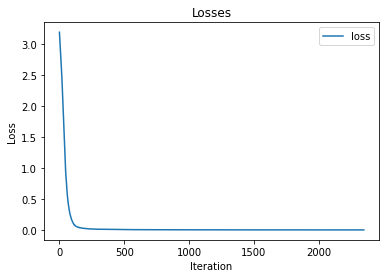

In [70]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [9]:
class BTWINS(nn.Module):
    def __init__(
        self,
        input_dim: int = 3,
        latent_dim: int = 128,
        lambd: float = 1e-2
    ):
        super(BTWINS, self).__init__()

        self.lambd = lambd
        self.model = Net(input_dim=3, latent_dim=latent_dim, conv_to_fc=8 * 8 * 4)

    def forward(self, x):
        return self.model(x)

    @staticmethod
    def off_diagonal(x):
        n = x.shape[0]
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def calculate_loss(self, batch):
        y_a, y_b = torch.chunk(batch, 2, dim=1)

        z_a, z_b = self(y_a), self(y_b)

        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0)
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0)

        c = z_a_norm.T @ z_b_norm

        c.div_(batch.shape[0])

        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal(c).pow_(2).sum()
        loss = on_diag + self.lambd * off_diag

        return loss

    def fit(self, train_dataloader, epochs=10, lr=1e-5):
        optim = opt.Adam(self.parameters(), lr=lr)

        losses = []

        for _ in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch = batch.to(device)

                loss = self.calculate_loss(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())

        return np.array(losses)

    @torch.no_grad()
    def encode(self, batch):
        self.eval()
        batch = batch.to(device)
        result = self(batch)
        self.train()
        return result        

In [10]:
class BTWINSDataset(Dataset):
    def __init__(self, image_dataset: Dataset):
        super().__init__()
        self.image_dataset = image_dataset
        self.transforms = transforms.Compose(
            [
             transforms.RandomHorizontalFlip(),
             transforms.RandomResizedCrop(32),
             transforms.GaussianBlur(9),
             transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
             transforms.RandomGrayscale(0.2),
             transforms.Normalize(0.5, 0.5),
            ]
        )

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, index):
        cur_image = self.image_dataset[index][0]
        return torch.cat([self.transforms(cur_image) for i in range(2)])

In [11]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

    batch_size = 256
    epochs = 10
    lr = 1e-5

    lambd = 0.01
    latent_dim = 128
    
    train_dataloader = DataLoader(
        BTWINSDataset(train_data), batch_size=batch_size, shuffle=True
    )

    model = BTWINS(input_dim=3, latent_dim=latent_dim, lambd=lambd).to(device)
    
    losses = model.fit(train_dataloader, epochs=epochs, lr=lr)
    
    return losses, model.encode

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

Files already downloaded and verified
Files already downloaded and verified


Training:   0%|          | 0/10 [00:00<?, ?it/s]

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)